### Import

In [71]:
import pandas as pd
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import joblib
from datetime import datetime
import random
from faker import Faker
from elasticsearch import Elasticsearch




nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Mise en forme des caractéres : tout en minuscule, suppression de la ponctuation et des chiffres 

In [72]:
df = pd.read_csv("Emotion_final.csv")
df = df.apply(lambda x: x.astype(str).str.lower())
df['Text'] = df['Text'].str.replace('[{}\d]'.format(string.punctuation), '', regex=True)

In [73]:
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,melissa stared at her friend in dism,fear
21455,successive state elections have seen the gover...,fear
21456,vincent was irritated but not dismay,fear
21457,kendallhume turned back to face the dismayed coup,fear


In [74]:
df.describe()

,Text,Emotion
count,21459,21459
unique,21405,6
top,i feel so tortured by it,happy
freq,2,7029


### Suppression des doublons

In [75]:
dup = df.duplicated()
dup.value_counts()

False    21456
True         3
dtype: int64

In [76]:
df = df.drop_duplicates(keep='last')

In [77]:
df.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [78]:
df.Emotion.value_counts()

happy       7028
sadness     6265
anger       2992
fear        2651
love        1641
surprise     879
Name: Emotion, dtype: int64

### Stopwords

In [79]:
stops = set(stopwords.words('english'))
nv_mots_stops = ['feel', 'feeling','feelings', 'look', 'days','life','like','im','really', 'see', 'life', 'today','didnt','go', 'know', 'get', 'want', 'would', 'time', 'little', 'ive', 'still', 'even', 'one',  'people', 'think', 'bit', 'things', 'much', 'dont', 'make', 'day', 'something', 'back', 'going', 'way', 'could']
stops.update(nv_mots_stops)

### Les 30 mots les plus frequents par sentiments

In [80]:
def top_30_mots(texts, n=30):
    mots = []
    for text in texts:
        for mot in text.split():
            if mot.isalpha() and mot not in stops:
                mots.append(mot)
    mot_freq = {mot: mots.count(mot) for mot in set(mots)}
    top_mots = sorted(mot_freq.items(), key=lambda x: x[1], reverse=True)[:n]
    return top_mots

sentiments = ['sadness', 'anger', 'love', 'surprise', 'fear', 'happy']

top_mots_par_sentiment = {}

for sentiment in sentiments:
    texts = df[df['Emotion'] == sentiment]['Text']
    top_mots = top_30_mots(texts)
    top_mots_par_sentiment[sentiment] = top_mots



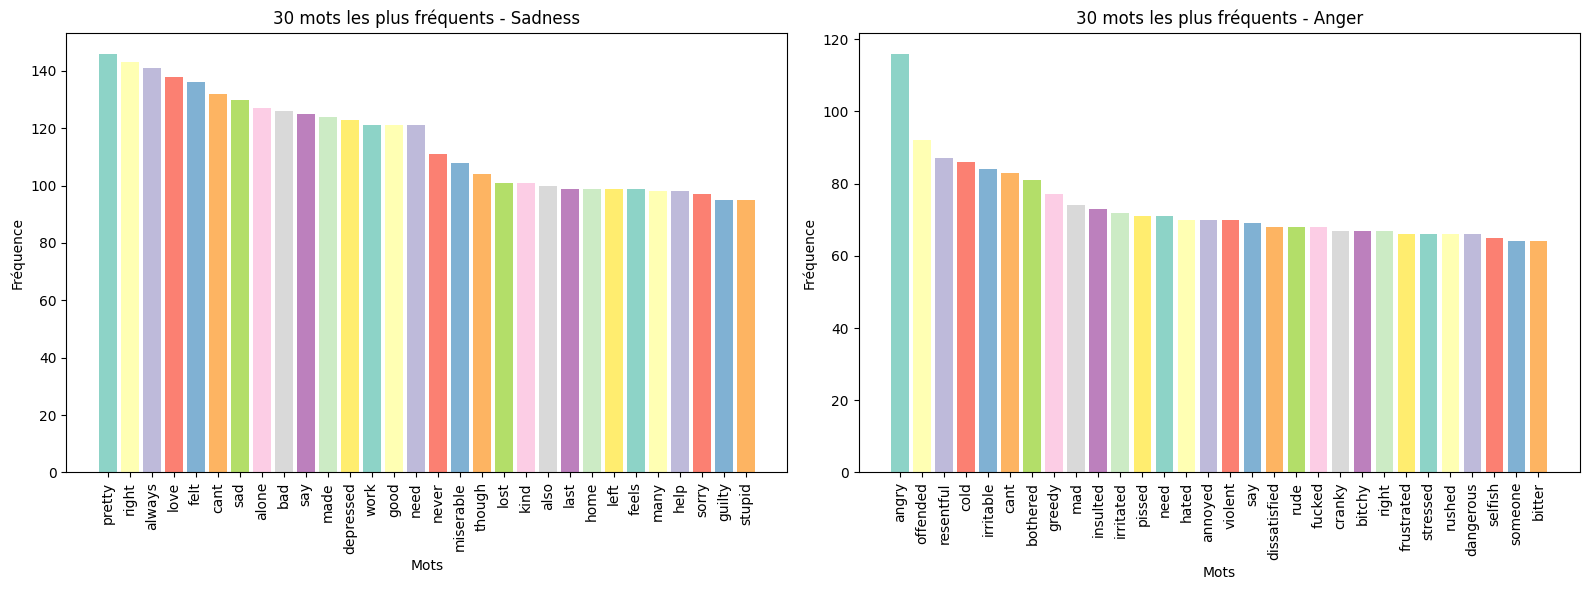

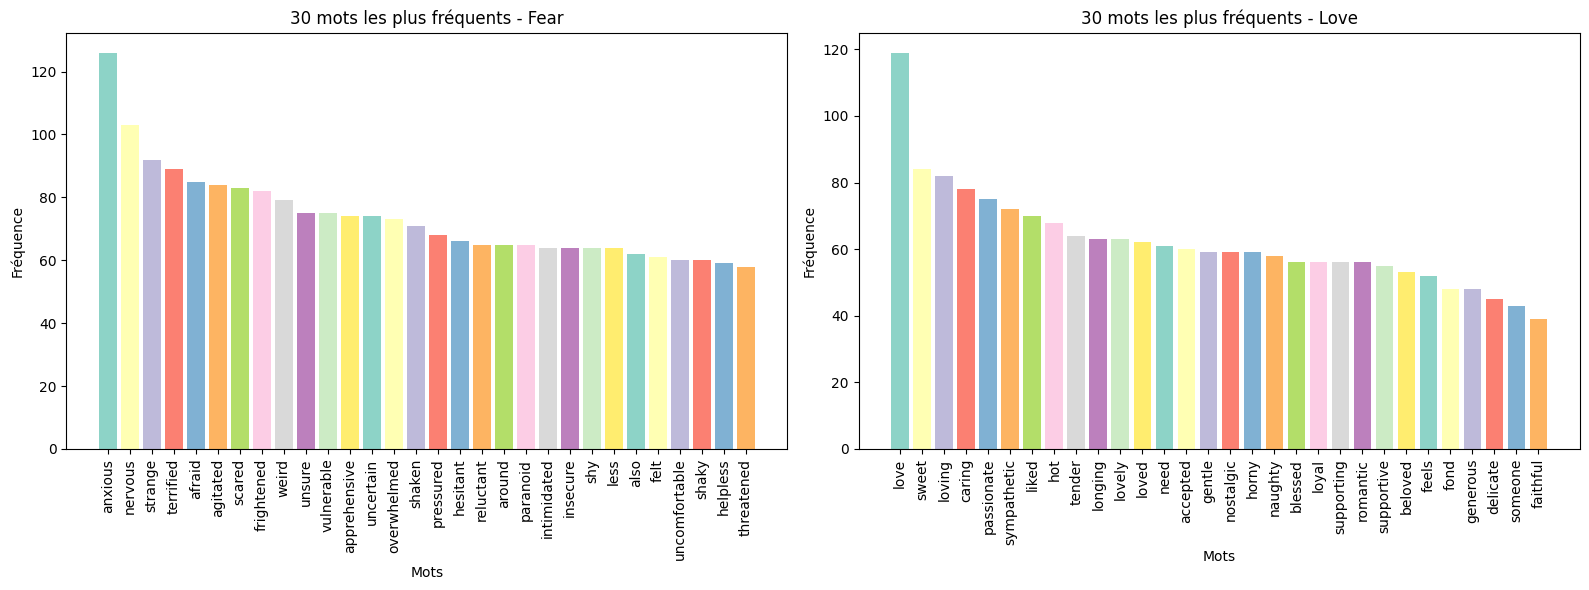

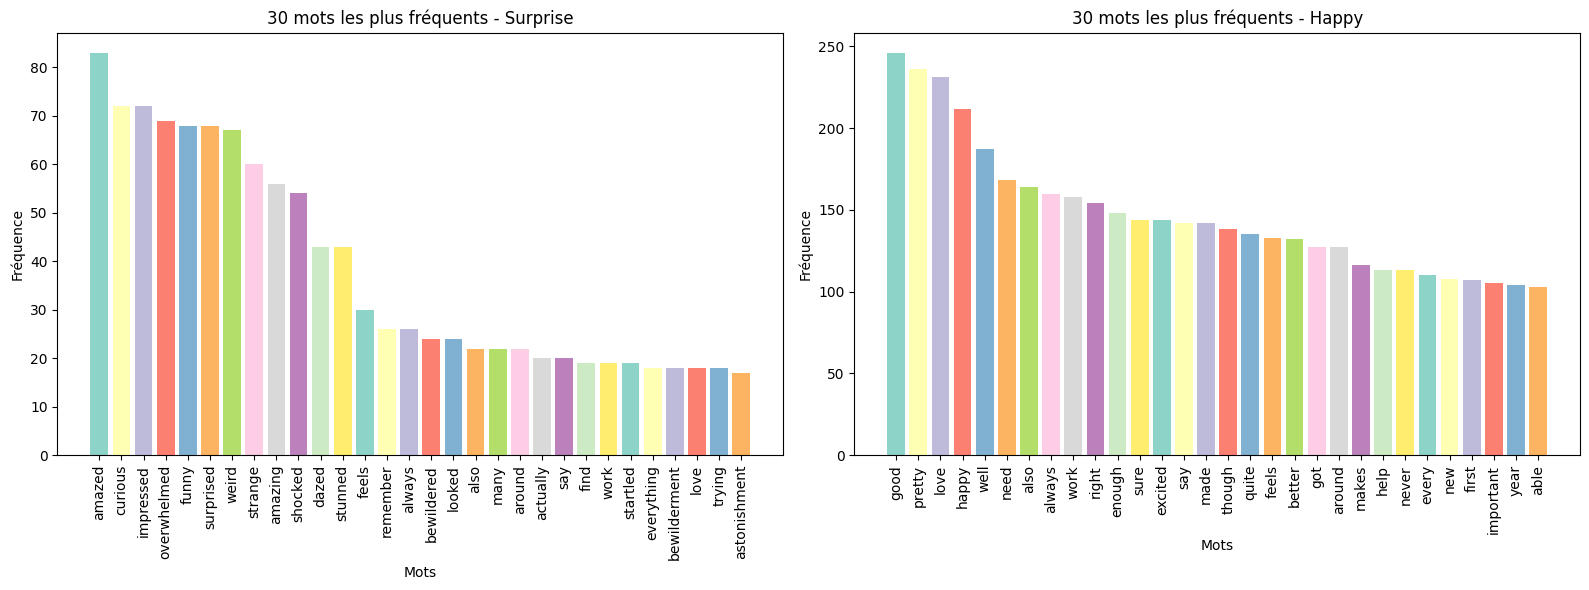

In [81]:
emotions1 = ["sadness", "anger"]
emotions2 = ["fear", "love"]
emotions3 = ["surprise", "happy"]

fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, emotion in enumerate(emotions1):
    top_mots_emotion = top_mots_par_sentiment[emotion]
    df1 = pd.DataFrame(top_mots_emotion, columns=["Mots", "Fréquence"])
    couleurs = sns.color_palette("Set3", len(df1))
    axes1[i].bar(df1["Mots"], df1["Fréquence"], color=couleurs)
    axes1[i].set_xlabel("Mots")
    axes1[i].set_ylabel("Fréquence")
    axes1[i].set_title(f"30 mots les plus fréquents - {emotion.capitalize()}")
    axes1[i].tick_params(axis='x', rotation=90)

fig1.tight_layout()

fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, emotion in enumerate(emotions2):
    top_mots_emotion = top_mots_par_sentiment[emotion]
    df1 = pd.DataFrame(top_mots_emotion, columns=["Mots", "Fréquence"])
    couleurs = sns.color_palette("Set3", len(df1))
    axes2[i].bar(df1["Mots"], df1["Fréquence"], color=couleurs)
    axes2[i].set_xlabel("Mots")
    axes2[i].set_ylabel("Fréquence")
    axes2[i].set_title(f"30 mots les plus fréquents - {emotion.capitalize()}")
    axes2[i].tick_params(axis='x', rotation=90)

fig2.tight_layout()

fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, emotion in enumerate(emotions3):
    top_mots_emotion = top_mots_par_sentiment[emotion]
    df1 = pd.DataFrame(top_mots_emotion, columns=["Mots", "Fréquence"])
    couleurs = sns.color_palette("Set3", len(df1))
    axes3[i].bar(df1["Mots"], df1["Fréquence"], color=couleurs)
    axes3[i].set_xlabel("Mots")
    axes3[i].set_ylabel("Fréquence")
    axes3[i].set_title(f"30 mots les plus fréquents - {emotion.capitalize()}")
    axes3[i].tick_params(axis='x', rotation=90)

fig3.tight_layout()

plt.show()

### HeatMap des mots les plus frequents par sentiment

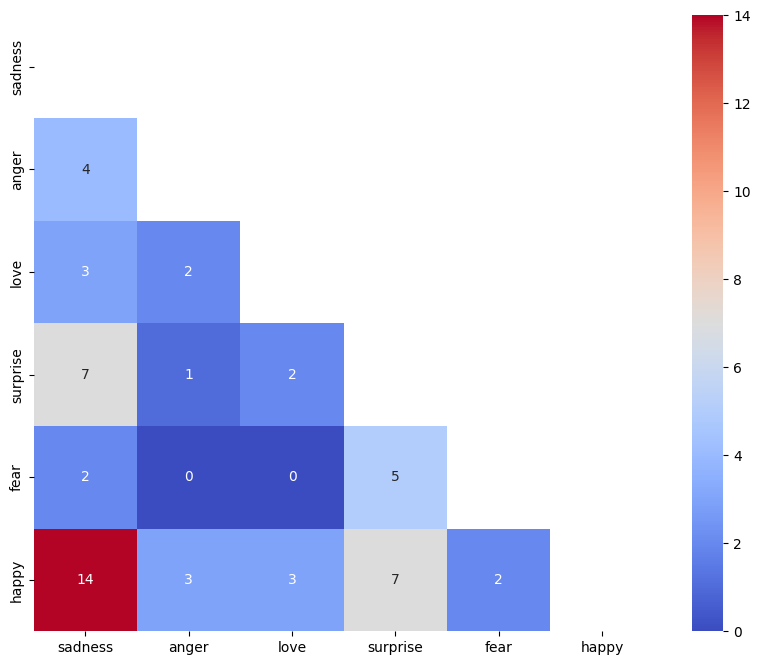

In [82]:
matrice = pd.DataFrame(index=sentiments, columns=sentiments)

for sentiment1 in sentiments:
    for sentiment2 in sentiments:
        mots1 = set(mot for mot, _ in top_mots_par_sentiment[sentiment1])
        mots2 = set(mot for mot, _ in top_mots_par_sentiment[sentiment2])
        mots_commmun = len(mots1 & mots2)
        matrice.loc[sentiment1, sentiment2] = mots_commmun

matrice = matrice.astype(int)   

mask = np.triu(np.ones_like(matrice, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, cmap='coolwarm', mask=mask)
plt.show()

    Pour chaque sentiment on calcule le nombre de mots en commun entre les 30 mots les plus fréquents en convertissant les listes de mots en ensemble. Ensuite on compte les mots qui apparaissent dans les deux set. Le nombre de mots en commun est ensuite affiché dans la matrice

## Modélisation
- bow avec LogisticRegression

In [83]:
nltk.download('punkt')
nltk.download('wordnet')

stops = list(stops)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    return ' '.join(lemmatizer.lemmatize(term) for term in word_tokenize(text.lower()) if term not in stops)

X = df['Text'].apply(preprocess_text)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words=stops)),
    ('clf', LogisticRegression()),# Meilleur paramétres C=20.52695741523762, max_iter=186, solver='saga', penalty='l1'
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, preds).round(2))

[nltk_data] Downloading package punkt to /home/apprenant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy:  0.89


/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- TFIDF avec RandomForestClassifier  

In [84]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stops = list(stops)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    return ' '.join(lemmatizer.lemmatize(term) for term in word_tokenize(text.lower()) if term not in stops)

X = df['Text'].apply(preprocess_text)
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stops)),
    ('clf', RandomForestClassifier()),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, preds).round(2))

joblib.dump(pipeline, 'model_tfidf.joblib')

[nltk_data] Downloading package punkt to /home/apprenant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/apprenant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy:  0.89


['model_tfidf.joblib']

## Stocker les données avec ElasticSearch

### Mise en place

- docker run -d -p 9200:9200 -v /usr/share/elasticsearch/data -e "discovery.type=single-node" --name elastic docker.elastic.co/elasticsearch/elasticsearch:7.17.10
- docker logs elastic
- curl http://localhost:9200/


### Mapper et importer les données 

In [86]:
es = Elasticsearch(hosts=["http://localhost:9200"])
model = joblib.load('model_tfidf.joblib')
fake = Faker()

In [88]:

mapping = {
    "mappings": {
        "properties": {
            "patient_lastname": {"type": "keyword"},
            "patient_firstname": {"type": "keyword"},
            "text": {"type": "text", "analyzer": "standard"},
            "date": {"type": "date"},
            "patient_left": {"type": "boolean"},
            "emotion": {"type": "keyword"},
            "confidence": {"type": "float"}
        }
    }
}

es.indices.create(index="notes", body=mapping)

csv_df = pd.read_csv('Emotion_final.csv')

patient_names = []
for _ in range(200):
    patient_names.append((fake.last_name(), fake.first_name()))

for i in range(csv_df.shape[0]):
    patient_lastname, patient_firstname = patient_names[i % 200]
    text = csv_df['Text'].iloc[i]
    date = fake.date_between(start_date='-1y', end_date='today')
    patient_left = fake.boolean()

    processed_text = preprocess_text(text)

    emotion = model.predict([processed_text])[0]
    confidence = model.predict_proba([processed_text])[0].max()

    document = {
        "patient_lastname": patient_lastname,
        "patient_firstname": patient_firstname,
        "text": text,
        "date": date,
        "patient_left": patient_left,
        "emotion": emotion,
        "confidence": confidence
    }

    es.index(index="notes", body=document)

print("La base de données Elasticsearch a été créée avec succès.")


/tmp/ipykernel_89380/733393088.py:15: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index="notes", body=mapping)
/tmp/ipykernel_89380/733393088.py:15: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index="notes", body=mapping)
/tmp/ipykernel_89380/733393088.py:44: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index="notes", body=document)
/tmp/ipykernel_89380/733393088.py:44: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication

La base de données Elasticsearch a été créée avec succès.


### Requetes

- Aboutir à un data frame permettant d’afficher la répartition des sentiments, des textes pour un patient en utilisant son nom / prenom


In [89]:
result = es.search(index='notes', body={
    "query": {
        "bool": {
            "must": [
                {"term": {"patient_lastname": "King"}},
                {"term": {"patient_firstname": "Penny"}}
            ]
        }
    },
    "_source": ["emotion", "text"], 
})

sentiments = [doc['_source']['emotion'] for doc in result['hits']['hits']]
texts = [doc['_source']['text'] for doc in result['hits']['hits']]

df_penny = pd.DataFrame({"Sentiment": sentiments, "Text": texts})


/tmp/ipykernel_89380/565314933.py:1: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index='notes', body={
/tmp/ipykernel_89380/565314933.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index='notes', body={


In [92]:
df_penny

,Sentiment,Text
0,happy,i also know how good it feels to look back and...
1,anger,i feel so fucked up now i want to shut myself up
2,fear,fear of thief
3,fear,i feel so shaken and guilty for not being a be...
4,fear,i feel fearful of being near them
5,happy,ive clawed time back and i still feel strong
6,love,i started feeling very gentle contractions abo...
7,happy,i was feeling brave tonight so i decided to go...
8,sadness,i went with one of those because honestly i wa...
9,sadness,i am right after my make up done i usually don...


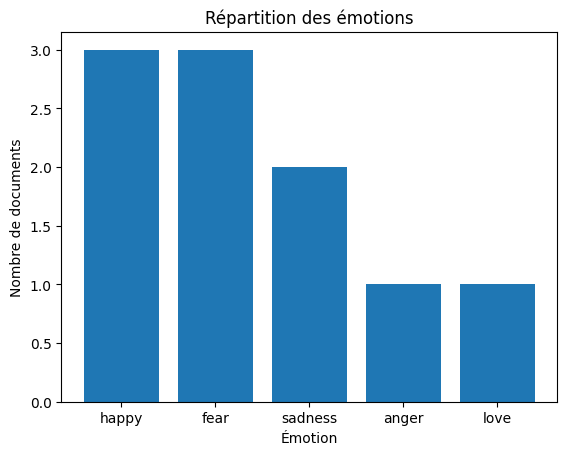

In [90]:

nb_emotion = df_penny['Sentiment'].value_counts()

plt.bar(nb_emotion.index, nb_emotion.values)
plt.xlabel('Émotion')
plt.ylabel('Nombre de documents')
plt.title('Répartition des émotions')
plt.show()


- Parmi les documents classifiés comme happy, quel pourcentage contient le mot "sadness", "fear", "anger", "love", "surprise" 
- Afficher sur un heatmap

/tmp/ipykernel_89380/969482400.py:1: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  reponse = es.search(
/tmp/ipykernel_89380/969482400.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  reponse = es.search(
/tmp/ipykernel_89380/969482400.py:19: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  reponse = es.scroll(


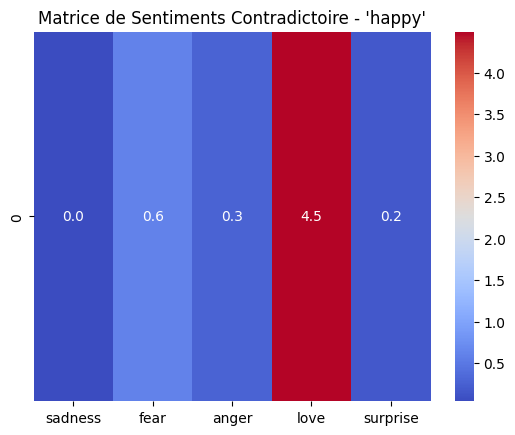

In [91]:
reponse = es.search(
    index="notes",
    body={
        "query": {
            "term": {
                "emotion": "happy"
            }
        },
        "size": 100  
    },
    scroll="2m"  
)

scroll_id = reponse["_scroll_id"]

happy_documents = [hit["_source"]["text"] for hit in reponse["hits"]["hits"]]

while len(reponse["hits"]["hits"]) > 0:
    reponse = es.scroll(
        scroll_id=scroll_id,
        scroll="2m"  
    )
    happy_documents += [hit["_source"]["text"] for hit in reponse["hits"]["hits"]]

mot_cles = ["sadness", "fear", "anger", "love", "surprise"]

nb_mots_cle = {}
for mot_cle in mot_cles:
    compte = sum(mot_cle.lower() in document.lower() for document in happy_documents)
    nb_mots_cle[mot_cle] = compte

doc_total = len(happy_documents)
mot_cle_pourcentage = {mot_cle: (compte / doc_total) * 100 for mot_cle, compte in nb_mots_cle.items()}

data = [[mot_cle_pourcentage[mot_cle] for mot_cle in mot_cles]]

sns.heatmap(data, cmap="coolwarm", annot=True, fmt=".1f", xticklabels=mot_cles)
plt.title("Matrice de Sentiments Contradictoire - 'happy'")
plt.show()
